# 数据处理

In [66]:
import pandas as pd
import numpy as np
# 读取附件1
df1 = pd.read_excel('附件1.xlsx')

# 读取附件2_filtered
df2 = pd.read_excel('附件2_filtered.xlsx')

# 读取附件3
df3 = pd.read_excel('附件3.xlsx')


In [67]:
product_category_mapping = dict(zip(df1['单品编码'], df1['分类编码']))

In [70]:
#df3 = pd.read_excel('附件3.xlsx')
# 创建每一天各个单品的进价的映射字典
date_product_cost_mapping = {}
for row in df3.itertuples():
    date = row.日期
    product_code = row.单品编码
    cost_price = row.批发价格
    
    if date not in date_product_cost_mapping:
        date_product_cost_mapping[date] = {}
    
    date_product_cost_mapping[date][product_code] = cost_price

In [11]:
df2 = pd.read_excel('附件2_filtered.xlsx')

In [34]:
# 创建每一天的总销售额、总进货价和总销售量的DataFrame
daily_sales_profit = pd.DataFrame(columns=['日期', '品类编码', '总销售额', '总进货价', '总销售量'])

# 遍历附件2中的数据，按日期和品类编码计算总销售额、总进货价和总销售量
for date, group in df2.groupby(['销售日期', '单品编码']):
    sales_date, product_code = date
    sales_quantity = group['销量'].sum()
    
    # 获取品类编码
    category_code = product_category_mapping.get(product_code, None)
    
    if category_code is not None:
        # 获取进价
        cost_price = date_product_cost_mapping.get(sales_date, {}).get(product_code, 0)
        
        # 计算销售额和进货价
        sales_amount = group['销售额'].sum()
        total_cost_price = sales_quantity * cost_price
        
        # 将结果添加到DataFrame中
        daily_sales_profit = pd.concat([daily_sales_profit, pd.DataFrame({'日期': [sales_date], '品类编码': [category_code],
                                                                         '总销售额': [sales_amount], '总进货价': [total_cost_price],
                                                                         '总销售量': [sales_quantity]})],
                                       ignore_index=True)

# 合并数据按品类编码计算总销售额、总进货价和总销售量
category_sales_profit = daily_sales_profit.groupby(['日期', '品类编码'])[['总销售额', '总进货价', '总销售量']].sum().reset_index()

In [85]:
# 将结果保存到Excel文件
category_sales_profit.to_excel('每天总销售额和总进货价.xlsx', index=False)

In [35]:
# 将单品编码映射为品类编码
df3['品类编码'] = df3['单品编码'].map(product_category_mapping)
# 计算每个品类每天的批发总价
df3['批发总价'] = df3['批发价格']

# 计算每个品类每天的平均批发价
category_avg_wholesale_price = df3.groupby(['日期', '品类编码'])['批发总价'].sum().reset_index()
category_avg_wholesale_price['平均批发价'] = category_avg_wholesale_price.groupby('品类编码')['批发总价'].transform('mean')


In [40]:
# 计算每个品类每天的平均批发价
category_avg_wholesale_price['平均批发价'] = category_avg_wholesale_price.groupby(['日期', '品类编码'])['平均批发价'].transform('mean')
# 合并平均批发价数据与销售数据
category_sales_profit = pd.merge(category_sales_profit, category_avg_wholesale_price[['日期', '品类编码', '平均批发价']], on=['日期', '品类编码'], how='left')


In [41]:
category_sales_profit

,日期,品类编码,总销售额,总进货价,总销售量,平均批发价_x,平均批发价_y
0,2020-07-01,1011010101,1503.7896,991.68855,205.402,83.154070,83.154070
1,2020-07-01,1011010201,592.5300,391.81200,46.640,12.056214,12.056214
2,2020-07-01,1011010402,70.2838,44.78568,4.850,27.509982,27.509982
3,2020-07-01,1011010501,176.8180,144.72835,35.374,19.240706,19.240706
4,2020-07-01,1011010504,759.9902,408.05555,76.715,89.995078,89.995078
...,...,...,...,...,...,...,...
6468,2023-06-30,1011010201,323.3425,222.12993,28.087,12.056214,12.056214
6469,2023-06-30,1011010402,274.9706,230.99253,19.188,27.509982,27.509982
6470,2023-06-30,1011010501,198.8132,115.19815,24.530,19.240706,19.240706
6471,2023-06-30,1011010504,501.6192,304.78078,82.286,89.995078,89.995078


# NARMAX

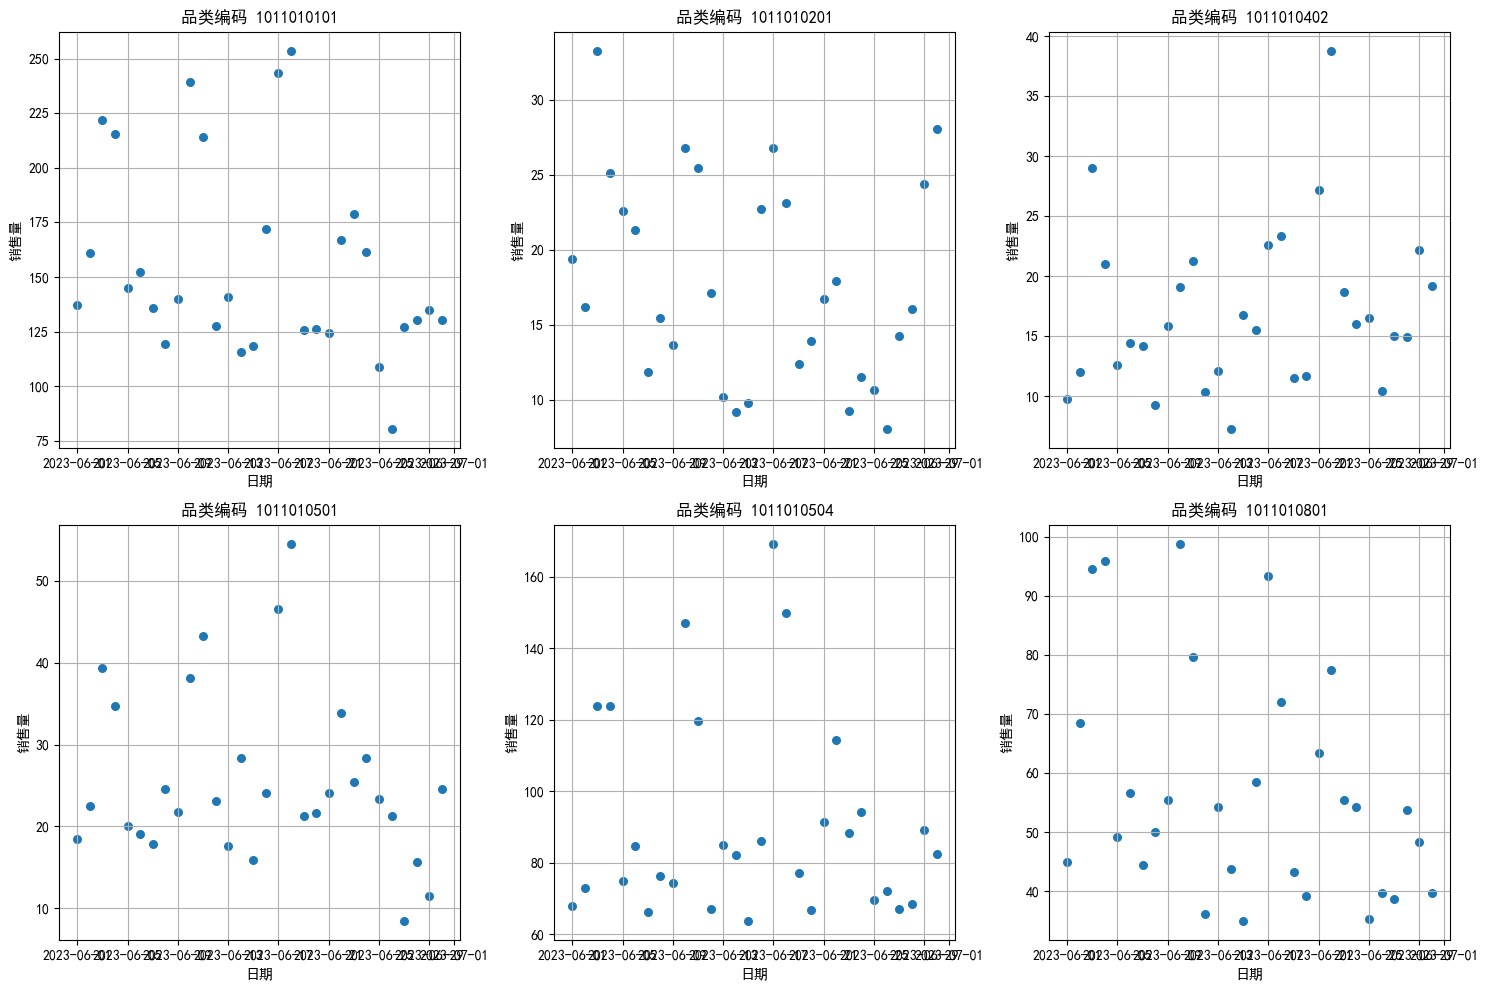

In [68]:
import matplotlib.pyplot as plt

# 选择2023年6月1日到2023年6月30日期间的数据
date_range = pd.date_range(start='2023-06-01', end='2023-06-30')

# 六个品类编码
categories = [1011010101, 1011010201, 1011010402, 1011010501, 1011010504, 1011010801]

# 创建一个包含六个子图的画布
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

# 遍历六个品类并绘制散点图
for i, category in enumerate(categories):
    row = i // 3
    col = i % 3
    
    # 选择特定品类的数据
    data = category_sales_profit[(category_sales_profit['品类编码'] == category) & (category_sales_profit['日期'].isin(date_range))]
    
    # 提取日期和销售量
    dates = data['日期']
    sales = data['总销售量']
    
    # 绘制散点图
    ax = axes[row, col]
    ax.scatter(dates, sales, marker='o', s=30)
    ax.set_title(f'品类编码 {category}')
    ax.set_xlabel('日期')
    ax.set_ylabel('销售量')
    ax.grid(True)

# 显示图形
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel


In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']

In [37]:
# 读取数据
data = pd.read_excel('每天总销售额和总进货价.xlsx')

In [40]:
# 筛选数据
start_date = '2023-01-01'
end_date = '2023-06-30'
categories = [1011010101, 1011010201, 1011010402, 1011010501, 1011010504, 1011010801]

filtered_data = data[(data['日期'] >= start_date) & (data['日期'] <= end_date)]


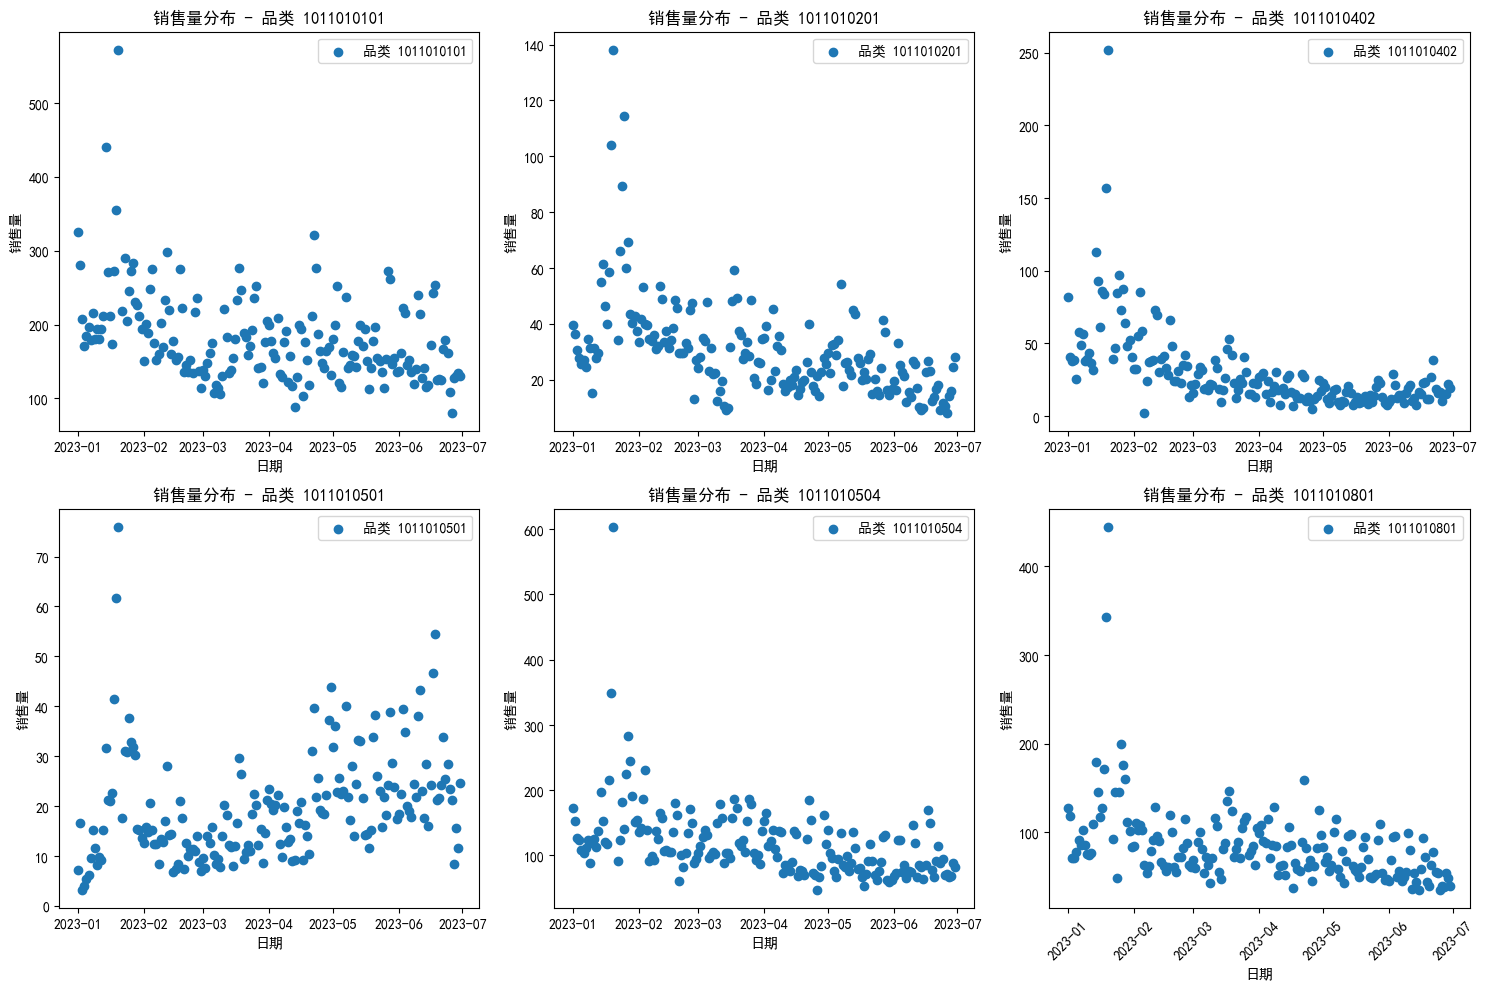

In [15]:
# 创建子图
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)
axs = axs.ravel()

# 循环绘制子图
for i, category in enumerate(categories):
    ax = axs[i]
    category_data = filtered_data[filtered_data['品类编码'] == category]
    
    ax.scatter(category_data['日期'], category_data['总销售量'], label=f'品类 {category}')
    ax.set_title(f'销售量分布 - 品类 {category}')
    ax.set_xlabel('日期')
    ax.set_ylabel('销售量')
    ax.legend()
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [57]:
# 筛选品类编码为指定的六个品类
selected_categories = [1011010101, 1011010201, 1011010402, 1011010501, 1011010504, 1011010801]
filtered_data = data[data['品类编码'].isin(selected_categories)]

# 将日期列转换为日期时间类型
filtered_data['日期'] = pd.to_datetime(filtered_data['日期'])


In [58]:
# 创建包含六个子数据集的字典
category_data_dict = {}
for category in selected_categories:
    category_data_dict[category] = filtered_data[filtered_data['品类编码'] == category]


D:\anaconda\envs\clone1\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
D:\anaconda\envs\clone1\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
D:\anaconda\envs\clone1\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
D:\anaconda\envs\clone1\lib\site-packages\sklearn\gaussian_process\kernels.py:419:

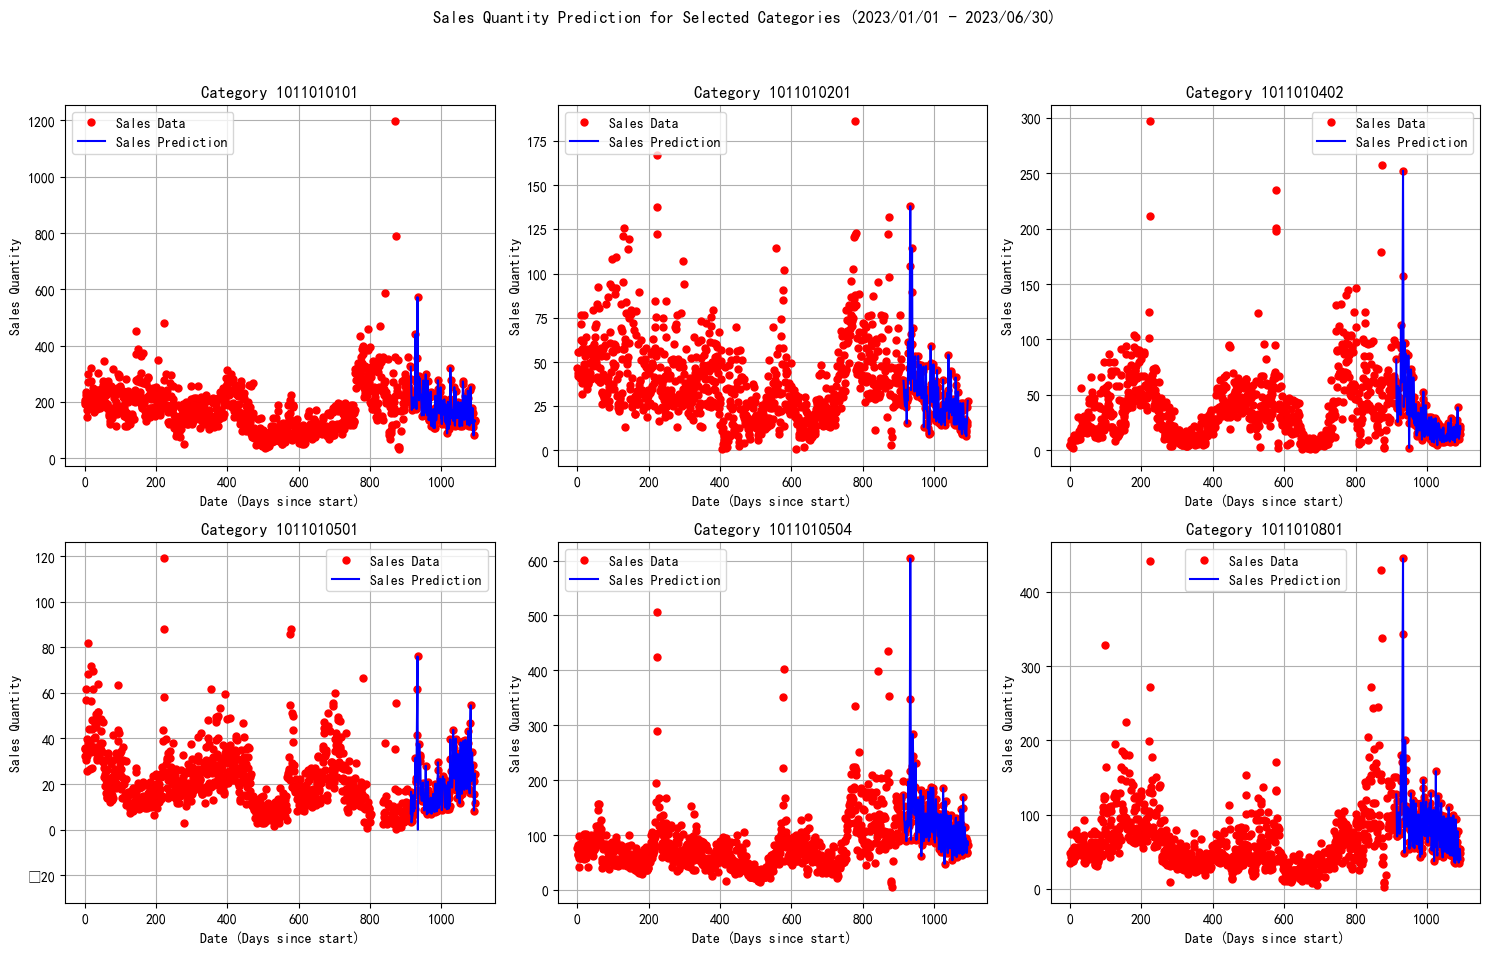

In [63]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt

# 读取包含日期、品类编码和总销售量的数据文件
data = pd.read_excel('每天总销售额和总进货价.xlsx')

# 筛选品类编码为指定的六个品类
selected_categories = [1011010101, 1011010201, 1011010402, 1011010501, 1011010504, 1011010801]
filtered_data = data[data['品类编码'].isin(selected_categories)]

# 将日期列转换为日期时间类型
filtered_data['日期'] = pd.to_datetime(filtered_data['日期'])

# 创建包含六个子数据集的字典
category_data_dict = {}
for category in selected_categories:
    category_data_dict[category] = filtered_data[filtered_data['品类编码'] == category]

# 定义日期范围
date_range = pd.date_range(start='2023-01-01', end='2023-06-30', freq='D')

# 定义高斯过程回归参数
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# 创建一个包含6个子图的画布
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Sales Quantity Prediction for Selected Categories (2023/01/01 - 2023/06/30)')

# 针对每个品类进行预测和绘图
for i, (category, category_data) in enumerate(category_data_dict.items()):
    # 将日期转换为数值类型（天数）
    X = (category_data['日期'] - category_data['日期'].min()).dt.days.values.reshape(-1, 1)
    y = category_data['总销售量'].values

    # 训练高斯过程回归模型
    gp.fit(X, y)

    # 将预测日期转换为数值类型
    X_pred = (date_range - category_data['日期'].min()).days.to_numpy().reshape(-1, 1)
    y_pred, sigma = gp.predict(X_pred, return_std=True)

    # 绘制销售量预测子图
    row = i // 3
    col = i % 3
    axs[row, col].set_title(f'Category {category}')
    axs[row, col].plot(X, y, 'r.', markersize=10, label='Sales Data')
    axs[row, col].plot(X_pred, y_pred, 'b-', label='Sales Prediction')
    axs[row, col].fill_between(X_pred[:, 0], y_pred - sigma, y_pred + sigma, alpha=0.2)
    axs[row, col].set_xlabel('Date (Days since start)')
    axs[row, col].set_ylabel('Sales Quantity')
    axs[row, col].legend()
    axs[row, col].grid(True)

# 调整子图布局
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 显示销售量预测图
plt.show()


# 打折率

In [83]:
# 创建每一天的总销售额、总进货价、总销售量和平均打折率的DataFrame
daily_sales_profit = pd.DataFrame(columns=['日期', '品类编码', '总销售额', '总进货价', '总销售量', '平均打折率'])

# 遍历附件2中的数据，按日期和品类编码计算总销售额、总进货价、总销售量和平均打折率
for date, group in df2.groupby(['销售日期', '单品编码']):
    sales_date, product_code = date
    sales_quantity = group['销量'].sum()
    
    # 获取品类编码
    category_code = product_category_mapping.get(product_code, None)
    
    if category_code is not None:
        # 获取进价
        cost_price = date_product_cost_mapping.get(sales_date, {}).get(product_code, 0)
        
        # 计算销售额和进货价
        sales_amount = group['销售额'].sum()
        total_cost_price = sales_quantity * cost_price
        
        # 计算打折率
        discount_prices = group[group['是否打折销售'] == '是']['销售单价(元/千克)'].tolist()
        regular_prices = group[group['是否打折销售'] == '否']['销售单价(元/千克)'].tolist()
        
        if discount_prices:
            avg_discount_rate = np.mean([discount / regular for discount, regular in zip(discount_prices, regular_prices) if discount != 1.0])
        else:
            avg_discount_rate = 1.0  # 如果没有打折，则打折率为1
        
        # 将结果添加到DataFrame中
        daily_sales_profit = pd.concat([daily_sales_profit, pd.DataFrame({'日期': [sales_date], '品类编码': [category_code],
                                                                         '总销售额': [sales_amount], '总进货价': [total_cost_price],
                                                                         '总销售量': [sales_quantity], '平均打折率': [avg_discount_rate]})],
                                       ignore_index=True)

# 合并数据按品类编码计算总销售额、总进货价、总销售量和平均打折率
category_sales_profit = daily_sales_profit.groupby(['日期', '品类编码'])[['总销售额', '总进货价', '总销售量', '平均打折率']].agg({'总销售额':'sum', '总进货价':'sum', '总销售量':'sum', '平均打折率': lambda x: np.mean([value for value in x if value != 1.0])}).reset_index()


D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\envs\clone1\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\envs

In [84]:
category_sales_profit

,日期,品类编码,总销售额,总进货价,总销售量,平均打折率
0,2020-07-01,1011010101,1503.7896,991.68855,205.402,0.797101
1,2020-07-01,1011010201,592.5300,391.81200,46.640,NaN
2,2020-07-01,1011010402,70.2838,44.78568,4.850,NaN
3,2020-07-01,1011010501,176.8180,144.72835,35.374,NaN
4,2020-07-01,1011010504,759.9902,408.05555,76.715,NaN
...,...,...,...,...,...,...
6468,2023-06-30,1011010201,323.3425,222.12993,28.087,0.777778
6469,2023-06-30,1011010402,274.9706,230.99253,19.188,NaN
6470,2023-06-30,1011010501,198.8132,115.19815,24.530,NaN
6471,2023-06-30,1011010504,501.6192,304.78078,82.286,0.600953


In [86]:
# 计算每个品类的历史总打折率
category_discount_rate = category_sales_profit[category_sales_profit['平均打折率'] != 1.0].groupby(['品类编码'])['平均打折率'].mean()

In [87]:
category_discount_rate

品类编码
1011010101    0.699937
1011010201    0.675847
1011010402    0.718194
1011010501    0.813046
1011010504    0.672934
1011010801    0.671256
Name: 平均打折率, dtype: float64

# 平均批发价格

In [89]:
# 创建每一天的平均批发价格的DataFrame
daily_avg_wholesale_price = pd.DataFrame(columns=['日期', '品类编码', '平均批发价格'])

# 遍历附件3中的数据，按日期和品类编码计算平均批发价格
for date, group in df3.groupby(['日期', '单品编码']):
    wholesale_date, product_code = date
    wholesale_price = group['批发价格'].mean()
    
    # 获取品类编码
    category_code = product_category_mapping.get(product_code, None)
    
    if category_code is not None:
        # 将结果添加到DataFrame中
        daily_avg_wholesale_price = pd.concat([daily_avg_wholesale_price, pd.DataFrame({'日期': [wholesale_date], '品类编码': [category_code],
                                                                                         '平均批发价格': [wholesale_price]})],
                                               ignore_index=True)

# 合并数据按品类编码计算平均批发价格
category_avg_wholesale_price = daily_avg_wholesale_price.groupby(['日期', '品类编码'])[['平均批发价格']].mean().reset_index()


In [90]:
category_avg_wholesale_price

,日期,品类编码,平均批发价格
0,2020-07-01,1011010101,5.333125
1,2020-07-01,1011010201,7.630000
2,2020-07-01,1011010402,17.540000
3,2020-07-01,1011010501,4.095000
4,2020-07-01,1011010504,7.197778
...,...,...,...
6540,2023-06-30,1011010201,7.813333
6541,2023-06-30,1011010402,12.035714
6542,2023-06-30,1011010501,4.402500
6543,2023-06-30,1011010504,5.731000


In [91]:
category_avg_wholesale_price.to_excel('平均批发价.xlsx', index=False)

# narmax算平均

C:\Users\LDH\AppData\Local\Temp\ipykernel_76952\2604972627.py:58: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
D:\anaconda\envs\clone1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


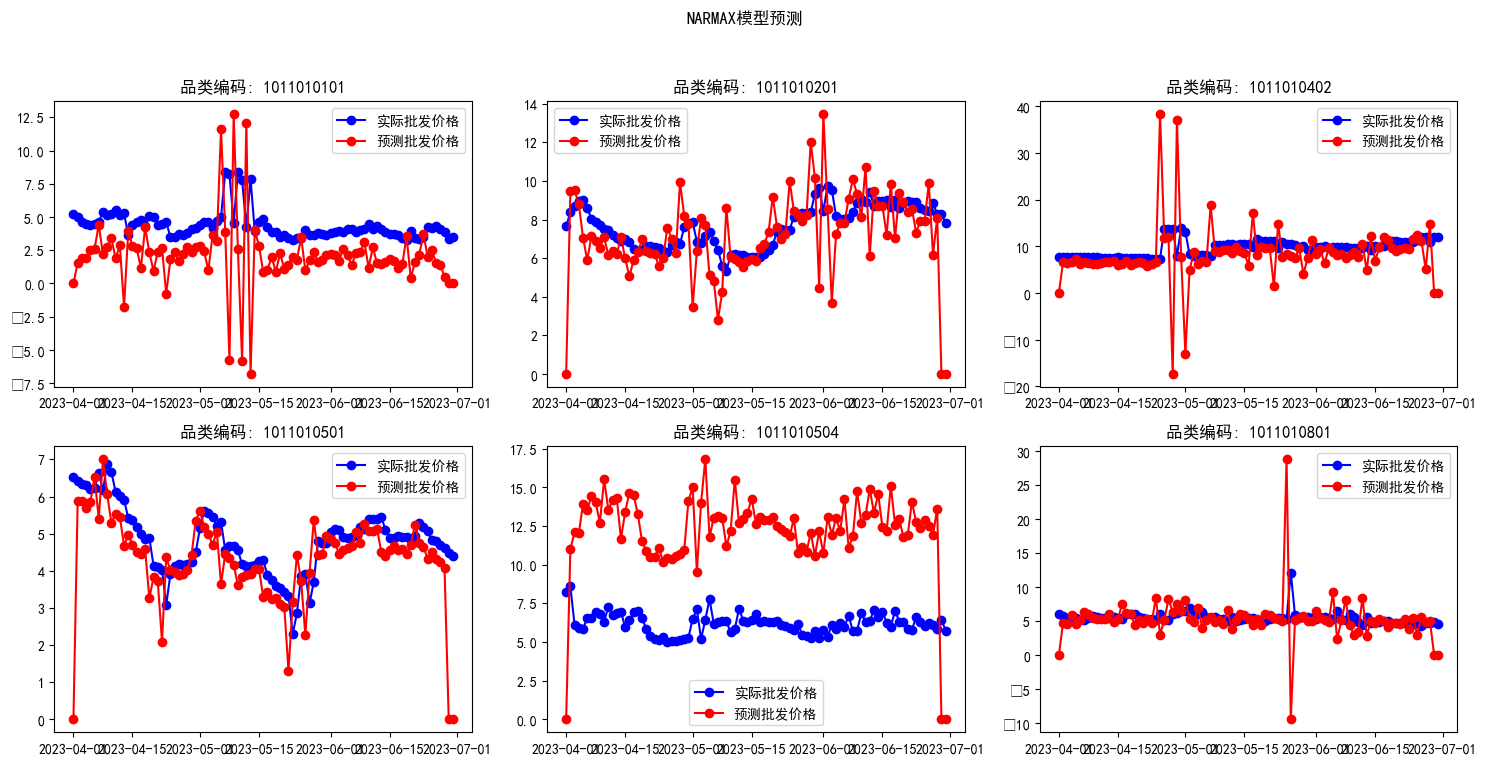

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 数据
dates = pd.date_range(start="2023-04-01", end="2023-06-30", freq="D")
category_codes = [1011010101, 1011010201, 1011010402, 1011010501, 1011010504, 1011010801]

# 拟合和预测的时间范围
fit_start_date = datetime(2023, 4, 1)
fit_end_date = datetime(2023, 6, 30)
forecast_start_date = datetime(2023, 4, 1)
forecast_end_date = datetime(2023, 7, 7)

# 初始化绘图
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('NARMAX模型预测')

for i, category_code in enumerate(category_codes):
    # 提取该品类的平均批发价格数据
    category_data = category_avg_wholesale_price[category_avg_wholesale_price['品类编码'] == category_code]
    category_data = category_data.set_index('日期')['平均批发价格']

    # 提取拟合和预测的数据
    fit_data = category_data[fit_start_date:fit_end_date]
    forecast_data = category_data[forecast_start_date:forecast_end_date]

    # 构建输入数据
    u = fit_data.values
    y = np.zeros(len(u))
    for j in range(2, len(u)):
        y[j] = 0.5 * y[j - 1] - 0.1 * y[j - 2] + 0.2 * u[j - 1] ** 2 + 0.1 * u[j - 2] * u[j - 1] + np.random.normal(0, 0.1)

    # 训练NARMAX模型
    n = 2
    m = 2
    y_pred, theta = narmax_model(y, u, n, m)

    # 预测
    forecast_u = forecast_data.values
    forecast_y_pred = np.zeros(len(forecast_u))
    for j in range(n + 1, len(forecast_u)):
        forecast_y_pred[j - n] = np.dot(theta[:n], forecast_y_pred[j - 1:j - n - 1:-1]) + np.dot(theta[n:], forecast_u[j - 1:j - m - 1:-1])

    # 绘制图表
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    x_fit = pd.date_range(start=fit_start_date, end=fit_end_date, freq="D")
    x_forecast = pd.date_range(start=fit_start_date, end=forecast_end_date, freq="D")

    ax.plot(x_fit, fit_data.values, 'o-', label='实际批发价格', color='blue')
    ax.plot(x_forecast, np.concatenate((forecast_y_pred, [None]*(len(x_forecast)-len(forecast_y_pred)))), 'o-', label='预测批发价格', color='red')
    ax.set_title(f'品类编码: {category_code}')
    ax.legend()

# 调整布局
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [184]:
# 将日期列转换为日期时间对象
category_sales_profit['日期'] = pd.to_datetime(category_sales_profit['日期'])

# 提取年份和日期列
category_sales_profit['年份'] = category_sales_profit['日期'].dt.year
category_sales_profit['日期'] = category_sales_profit['日期'].dt.date

# 按年份和品类编码分组，并计算每天的销售总量
daily_category_sales = category_sales_profit.groupby(['年份', '日期', '品类编码'])['总销售量'].sum().reset_index()

# 按年份和日期分组，并计算每天六个品类的销售总量
daily_total_category_sales = daily_category_sales.groupby(['年份', '日期'])['总销售量'].sum().reset_index()

# 打印结果
daily_total_category_sales.head()


,年份,日期,总销售量
0,2020,2020-07-01,404.346
1,2020,2020-07-02,393.678
2,2020,2020-07-03,385.018
3,2020,2020-07-04,483.299
4,2020,2020-07-05,516.917


In [146]:
daily_total_category_sales.to_excel('销售量.xlsx', index=False)

# 数学规划

## 7/1

In [189]:
from scipy.optimize import linprog

# 系数
a = [-0.00637, 0.015, 0.0185, -0.00329, -0.00405, 0.0796]
b = [1.3326, 1.2708, 1.1832, 1.4151, 1.3411, 1.2315]
z = [10.6448, 3.1431, 5.7174, 4.6973, 4.3784, 7.2234]
alpha = [0.102803, 0.14142, 0.119747, 0.07122, 0.085153, 0.0813097]
rho = [0.699937, 0.675847, 0.718194, 0.813046, 0.672934, 0.671256]

# 下限和上限
lower_bounds = [135.0464, 17.1808, 0, 7.5831, 25.8570, 27.6851]
upper_bounds = [163.2700, 45.4364, 25.9125, 35.8387, 54.0805, 55.9086]

# 销售总量上限
total_sales_limit = 280

# 构建线性规划问题
c = [-1 * (a[i] + b[i] * z[i]) for i in range(6)]
A = [[1, 1, 1, 1, 1, 1]]
b_eq = [total_sales_limit]

bounds = [(lower_bounds[i], upper_bounds[i]) for i in range(6)]

# 求解线性规划
result = linprog(c, A_eq=A, b_eq=b_eq, bounds=bounds)

# 检查是否成功找到最优解
if result.success:
    optimal_prices = result.x[:6]
    optimal_sales = result.x[6:]
    print("Optimal Prices:", optimal_prices)
    print("Optimal Sales:", optimal_sales)
else:
    print("No optimal solution found.")


Optimal Prices: [163.27    17.1808  10.2005   7.5831  25.857   55.9086]
Optimal Sales: []


## 7/2

In [153]:
# 系数
a = [-0.00637, 0.015, 0.0185, -0.00329, -0.00405, 0.0796]
b = [1.3326, 1.2708, 1.1832, 1.4151, 1.3411, 1.2315]
z = [11.7968,2.8713,6.0211,4.6759,4.7261,7.0769]
alpha = [0.102803, 0.14142, 0.119747, 0.07122, 0.085153, 0.0813097]
rho = [0.699937, 0.675847, 0.718194, 0.813046, 0.672934, 0.671256]

# 下限和上限
lower_bounds = [150.3257 ,26.2785 ,5.6226 ,13.8908 ,39.7789 ,25.8648]
upper_bounds = [178.5493,54.5340 ,33.8461 ,42.1463 ,68.0024 ,54.0883]

# 销售总量上限
total_sales_limit = 280

# 构建线性规划问题
c = [-1 * (a[i] + b[i] * z[i]) for i in range(6)]
A = [[1, 1, 1, 1, 1, 1]]
b_eq = [total_sales_limit]

bounds = [(lower_bounds[i], upper_bounds[i]) for i in range(6)]

# 求解线性规划
result = linprog(c, A_eq=A, b_eq=b_eq, bounds=bounds)

# 检查是否成功找到最优解
if result.success:
    optimal_prices = result.x[:6]
    optimal_sales = result.x[6:]
    print("销量:", optimal_prices)


销量: [168.5644  26.2785   5.6226  13.8908  39.7789  25.8648]


## 7/3

In [186]:
# 系数
a = [-0.00637, 0.015, 0.0185, -0.00329, -0.00405, 0.0796]
b = [1.3326, 1.2708, 1.1832, 1.4151, 1.3411, 1.2315]
z = [11.9516,3.3694,4.9116,4.4119,5.3043,7.598]
alpha = [0.102803, 0.14142, 0.119747, 0.07122, 0.085153, 0.0813097]
rho = [0.699937, 0.675847, 0.718194, 0.813046, 0.672934, 0.671256]

# 下限和上限
lower_bounds = [179.1851 ,34.0929 ,32.6539 ,24.7003 ,46.9820 ,35.4039]
upper_bounds = [207.4086 ,62.3485 ,60.8774,58.9559 ,80.2055 ,68.6274]

# 销售总量上限
total_sales_limit = 365

# 构建线性规划问题
c = [-1 * (a[i] + b[i] * z[i]) for i in range(6)]
A = [[1, 1, 1, 1, 1, 1]]
b_eq = [total_sales_limit]

bounds = [(lower_bounds[i], upper_bounds[i]) for i in range(6)]

# 求解线性规划
result = linprog(c, A_eq=A, b_eq=b_eq, bounds=bounds)

# 检查是否成功找到最优解
if result.success:
    optimal_prices = result.x[:6]
    optimal_sales = result.x[6:]
    print("销量:", optimal_prices)


销量: [191.167   34.0929  32.6539  24.7003  46.982   35.4039]


## 7.4

In [182]:
# 系数
a = [-0.00637, 0.015, 0.0185, -0.00329, -0.00405, 0.0796]
b = [1.3326, 1.2708, 1.1832, 1.4151, 1.3411, 1.2315]
z = [11.9764,3.7993,6.5723,4.8605,4.8524,5.8097]
alpha = [0.102803, 0.14142, 0.119747, 0.07122, 0.085153, 0.0813097]
rho = [0.699937, 0.675847, 0.718194, 0.813046, 0.672934, 0.671256]

# 下限和上限
lower_bounds = [142.8882 ,22.6847 ,8.1070 ,14.3878 ,38.4117 ,26.4664]
upper_bounds = [171.1118 ,50.9403 ,36.3305 ,42.6434 ,66.6352 ,54.6899]

# 销售总量上限
total_sales_limit = 280

# 构建线性规划问题
c = [-1 * (a[i] + b[i] * z[i]) for i in range(6)]
A = [[1, 1, 1, 1, 1, 1]]
b_eq = [total_sales_limit]

bounds = [(lower_bounds[i], upper_bounds[i]) for i in range(6)]

# 求解线性规划
result = linprog(c, A_eq=A, b_eq=b_eq, bounds=bounds)

# 检查是否成功找到最优解
if result.success:
    optimal_prices = result.x[:6]
    optimal_sales = result.x[6:]
    print("销量:", optimal_prices)


销量: [169.9424  22.6847   8.107   14.3878  38.4117  26.4664]


## 7/5

In [166]:
# 系数
a = [-0.00637, 0.015, 0.0185, -0.00329, -0.00405, 0.0796]
b = [1.3326, 1.2708, 1.1832, 1.4151, 1.3411, 1.2315]
z = [11.5712,3.8319,7.5563,5.0261,4.4978,5.2242]
alpha = [0.102803, 0.14142, 0.119747, 0.07122, 0.085153, 0.0813097]
rho = [0.699937, 0.675847, 0.718194, 0.813046, 0.672934, 0.671256]

# 下限和上限
lower_bounds = [140.6695 ,40.3566 ,10.6226 ,19.4347 ,37.6929 ,29.8257]
upper_bounds = [168.8930 ,68.6122 ,38.8461 ,47.6903 ,65.9165 ,58.0493]

# 销售总量上限
total_sales_limit = 280

# 构建线性规划问题
c = [-1 * (a[i] + b[i] * z[i]) for i in range(6)]
A = [[1, 1, 1, 1, 1, 1]]
b_eq = [total_sales_limit]

bounds = [(lower_bounds[i], upper_bounds[i]) for i in range(6)]

# 求解线性规划
result = linprog(c, A_eq=A, b_eq=b_eq, bounds=bounds)

# 检查是否成功找到最优解
if result.success:
    optimal_prices = result.x[:6]
    optimal_sales = result.x[6:]
    print("销量:", optimal_prices)


销量: [142.0675  40.3566  10.6226  19.4347  37.6929  29.8257]


## 7/6

In [188]:
# 系数
a = [-0.00637, 0.015, 0.0185, -0.00329, -0.00405, 0.0796]
b = [1.3326, 1.2708, 1.1832, 1.4151, 1.3411, 1.2315]
z = [8.1742,3.5956,4.9955,5.0159,4.4557,6.4515]
alpha = [0.102803, 0.14142, 0.119747, 0.07122, 0.085153, 0.0813097]
rho = [0.699937, 0.675847, 0.718194, 0.813046, 0.672934, 0.671256]

# 下限和上限
lower_bounds = [155.0445 ,23.9113 ,9.3257 ,14.8722 ,34.7242 ,20.1851]
upper_bounds = [183.2680 ,52.1669 ,37.5493 ,43.1278 ,62.9477 ,48.4086]

# 销售总量上限
total_sales_limit = 280

# 构建线性规划问题
c = [-1 * (a[i] + b[i] * z[i]) for i in range(6)]
A = [[1, 1, 1, 1, 1, 1]]
b_eq = [total_sales_limit]

bounds = [(lower_bounds[i], upper_bounds[i]) for i in range(6)]

# 求解线性规划
result = linprog(c, A_eq=A, b_eq=b_eq, bounds=bounds)

# 检查是否成功找到最优解
if result.success:
    optimal_prices = result.x[:6]
    optimal_sales = result.x[6:]
    print("销量:", optimal_prices)


销量: [176.9815  23.9113   9.3257  14.8722  34.7242  20.1851]


## 7/7

In [169]:
# 系数
a = [-0.00637, 0.015, 0.0185, -0.00329, -0.00405, 0.0796]
b = [1.3326, 1.2708, 1.1832, 1.4151, 1.3411, 1.2315]
z = [12.0158,3.4676,7.2284,5.0966,4.9757,5.9376]
alpha = [0.102803, 0.14142, 0.119747, 0.07122, 0.085153, 0.0813097]
rho = [0.699937, 0.675847, 0.718194, 0.813046, 0.672934, 0.671256]

# 下限和上限
lower_bounds = [124.5523 ,31.5988 ,11.6226 ,9.0441 ,24.9468 ,13.5328]
upper_bounds = [152.7758 ,59.8544 ,39.8461 ,37.2997 ,53.1704 ,41.7563]

# 销售总量上限
total_sales_limit = 280

# 构建线性规划问题
c = [-1 * (a[i] + b[i] * z[i]) for i in range(6)]
A = [[1, 1, 1, 1, 1, 1]]
b_eq = [total_sales_limit]

bounds = [(lower_bounds[i], upper_bounds[i]) for i in range(6)]

# 求解线性规划
result = linprog(c, A_eq=A, b_eq=b_eq, bounds=bounds)

# 检查是否成功找到最优解
if result.success:
    optimal_prices = result.x[:6]
    optimal_sales = result.x[6:]
    print("销量:", optimal_prices)


销量: [152.7758  31.5988  39.8461   9.0441  24.9468  21.7884]
